In [69]:
import pprint
import ccxt
binance = ccxt.binance () # Loads Binance
binance.load_markets ()
print ('binance: %d markets loaded!' % len (binance.markets))
cobinhood = ccxt.binance()
cobinhood.load_markets()
print ('cobinhood: %d markets loaded!' % len (cobinhood.markets))

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use ('seaborn-white')
plt.rcParams["figure.figsize"] = [15,6]

import pandas as pd
from datetime import datetime
import numpy as np
import time
import talib

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score

binance: 501 markets loaded!
cobinhood: 501 markets loaded!


In [45]:
ohlcv = binance.fetch_ohlcv('ETH/USDT', '1m', limit=1000)
data = pd.DataFrame(ohlcv, columns = ['date','open','high','low','close','volume'])
data['date'] = pd.to_datetime(data['date'],unit='ms')
data.set_index('date', inplace=True)
#data['change'] = np.where(data['close'].shift(-1) > data['close'],1,-1)
data['change_pct'] = (data['close'].shift(-1) - data['close'])/data['close']*100
print(data.head)

<bound method NDFrame.head of                        open    high     low   close     volume  change_pct
date                                                                      
2019-04-08 10:07:00  179.93  180.02  179.93  179.97  195.94398   -0.027782
2019-04-08 10:08:00  179.98  180.02  179.92  179.92  360.24158   -0.027790
2019-04-08 10:09:00  179.97  180.00  179.83  179.87   85.01352   -0.016679
2019-04-08 10:10:00  179.84  179.93  179.80  179.84   99.26450   -0.161254
2019-04-08 10:11:00  179.85  179.88  179.47  179.55  255.47880   -0.111390
2019-04-08 10:12:00  179.55  179.61  179.34  179.35  398.77405   -0.022303
2019-04-08 10:13:00  179.35  179.39  179.26  179.31  195.66144    0.061346
2019-04-08 10:14:00  179.31  179.45  179.25  179.42  239.29706    0.133764
2019-04-08 10:15:00  179.40  179.70  179.40  179.66  265.19333    0.061227
2019-04-08 10:16:00  179.66  179.77  179.62  179.77  249.05001   -0.066752
2019-04-08 10:17:00  179.77  179.77  179.64  179.65  142.84120   -0.09

In [26]:

#ohlcv = binance.fetch_ohlcv('ETH/USDT', '1m')
data = pd.DataFrame(ohlcv, columns = ['epoch','open','high','low','close','volume'])
data['datetime'] = datetime.fromtimestamp(data['epoch'])
#ts = datetime.datetime.fromtimestamp(ts_epoch).strftime('%Y-%m-%d %H:%M:%S')
print(data)

TypeError: cannot convert the series to <class 'int'>

In [71]:
# all-in-one SVC predictor on entirety of SP500

start = time.time()

accuracy_results = {}
returns = {}
loop = 1

for ticker in list(cobinhood.markets.keys()):
    try:
        loop_start = time.time()
        #download current ticker data
        print(" ")
        print("********************************")
        print(ticker, " starting: ", loop)
        loop += 1

        ohlcv = binance.fetch_ohlcv(ticker, '1m', limit=1000)
        data = pd.DataFrame(ohlcv, columns = ['date','open','high','low','close','volume'])
        data['date'] = pd.to_datetime(data['date'],unit='ms')
        data.set_index('date', inplace=True)

        # at this point, data should be a df w/ columns ['open','high','low','close','volume']
        data.loc[:, 'open-close'] = data['open'] - data['close']
        data.loc[:, 'high-low'] = data['high'] - data['low']
        data.loc[:, 'MACD'] = talib.MACD(data['close'].values)[0]
        data.loc[:, 'MACD_SIG'] = talib.MACD(data['close'].values)[1]
        data.loc[:, 'MACD_HIST'] = talib.MACD(data['close'].values)[2]
        data.loc[:, 'RSI'] = talib.RSI(data['close'].values)

        X_temp = data.drop(columns=['open','high','low','volume']).dropna()
        y = np.where(X_temp['close'].shift(-1) > X_temp['close'],1,-1)
        X = X_temp.drop(columns='close')


        # split data into training / test
        split_percentage = 0.8
        split = int(split_percentage*len(data))
        #print("Split: ", split)
        # Train data set
        X_train = X[:split].values
        y_train = y[:split]
        # Test data set
        X_test = X[split:].values
        y_test = y[split:]
        #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        #print(y_test)

        #print(ticker, " data.loc shape: ", data.loc[:, ticker].shape)
        print(ticker, " X_temp shape: ", X_temp.shape)
        print(ticker, " X_train shape: ", X_train.shape)
        print(ticker, " X_test shape: ", X_test.shape)
        print(ticker, " y_train shape: ", y_train.shape)
        print(ticker, " y_test shape: ", y_test.shape)        

        # train
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        cls = SVC().fit(X_train, y_train)

        # accuracies
        accuracy_train = accuracy_score(y_train, cls.predict(X_train))
        accuracy_test = accuracy_score(y_test, cls.predict(X_test))
        print("results:")
        print('Train Accuracy:{: .2f}%'.format(accuracy_train*100))
        print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))
        # append to accuracy_results dict
        accuracy_results[ticker] = (accuracy_train*100, accuracy_test*100)

        predicted_signal = cls.predict(X_test)
        return_ = np.log(X_temp[split:].close.shift(-1) / X_temp[split:].close)*100 #X_temp[split:] == X_test
        #return_ = (X_temp[split:].close.shift(-1) / X_temp[split:].close)*100 #X_temp[split:] == X_test
        strategy_return = return_ * predicted_signal
        #print("Return difference: ", strategy_return[split:].cumsum()[len(strategy_return)-2] - return_[split:].cumsum()[len(return_)-2])
        print("Return difference: ", strategy_return.cumsum()[len(strategy_return)-2] - return_.cumsum()[len(return_)-2])
        returns[ticker] = [accuracy_train*100, accuracy_test*100, return_.cumsum().iloc[-2], strategy_return.cumsum().iloc[-2]]

        loop_end = time.time()
        print("Loop run-time: ", (loop_end - loop_start))
        
    except Exception as e: 
        print("ERROR: ", e)
        print(ticker, "FAILED!!!")
        accuracy_results[ticker] = (0,0)
        returns[ticker] = [0,0,0,0]
        loop_end = time.time()
        print("Loop run-time: ", (loop_end - loop_start))
        
end = time.time()
print("Script run-time: ", (end - start))
        
df_returns = pd.DataFrame.from_dict(returns, columns=['Train Accuracy','Test Accuracy','Hold Return', 'Strategy Return'], orient='index')
df_returns.to_csv("cctx_testing_cobinhood.csv")

#winsound.Beep(1000,1000)

 
********************************
ETH/BTC  starting:  1
ETH/BTC  X_temp shape:  (967, 7)
ETH/BTC  X_train shape:  (800, 6)
ETH/BTC  X_test shape:  (167, 6)
ETH/BTC  y_train shape:  (800,)
ETH/BTC  y_test shape:  (167,)
results:
Train Accuracy: 62.00%
Test Accuracy: 54.49%
Return difference:  1.8572518968618734
Loop run-time:  5.462779998779297
 
********************************
LTC/BTC  starting:  2
LTC/BTC  X_temp shape:  (967, 7)
LTC/BTC  X_train shape:  (800, 6)
LTC/BTC  X_test shape:  (167, 6)
LTC/BTC  y_train shape:  (800,)
LTC/BTC  y_test shape:  (167,)
results:
Train Accuracy: 62.38%
Test Accuracy: 54.49%
Return difference:  2.6986109006514525
Loop run-time:  0.5492057800292969
 
********************************
BNB/BTC  starting:  3
BNB/BTC  X_temp shape:  (967, 7)
BNB/BTC  X_train shape:  (800, 6)
BNB/BTC  X_test shape:  (167, 6)
BNB/BTC  y_train shape:  (800,)
BNB/BTC  y_test shape:  (167,)
results:
Train Accuracy: 59.00%
Test Accuracy: 47.90%
Return difference:  0.577798582

YOYOW/BTC  X_temp shape:  (967, 7)
YOYOW/BTC  X_train shape:  (800, 6)
YOYOW/BTC  X_test shape:  (167, 6)
YOYOW/BTC  y_train shape:  (800,)
YOYOW/BTC  y_test shape:  (167,)
results:
Train Accuracy: 85.38%
Test Accuracy: 72.46%
Return difference:  1.8596235662471372e-14
Loop run-time:  0.4046907424926758
 
********************************
OMG/BTC  starting:  26
OMG/BTC  X_temp shape:  (967, 7)
OMG/BTC  X_train shape:  (800, 6)
OMG/BTC  X_test shape:  (167, 6)
OMG/BTC  y_train shape:  (800,)
OMG/BTC  y_test shape:  (167,)
results:
Train Accuracy: 77.88%
Test Accuracy: 83.23%
Return difference:  0.46029939765548633
Loop run-time:  0.3837251663208008
 
********************************
OMG/ETH  starting:  27
OMG/ETH  X_temp shape:  (967, 7)
OMG/ETH  X_train shape:  (800, 6)
OMG/ETH  X_test shape:  (167, 6)
OMG/ETH  y_train shape:  (800,)
OMG/ETH  y_test shape:  (167,)
results:
Train Accuracy: 78.50%
Test Accuracy: 86.83%
Return difference:  -1.7602045156775339
Loop run-time:  0.361368179321

SALT/BTC  X_temp shape:  (967, 7)
SALT/BTC  X_train shape:  (800, 6)
SALT/BTC  X_test shape:  (167, 6)
SALT/BTC  y_train shape:  (800,)
SALT/BTC  y_test shape:  (167,)
results:
Train Accuracy: 90.50%
Test Accuracy: 85.03%
Return difference:  6.482048830150899
Loop run-time:  0.4642505645751953
 
********************************
SALT/ETH  starting:  50
SALT/ETH  X_temp shape:  (967, 7)
SALT/ETH  X_train shape:  (800, 6)
SALT/ETH  X_test shape:  (167, 6)
SALT/ETH  y_train shape:  (800,)
SALT/ETH  y_test shape:  (167,)
results:
Train Accuracy: 94.00%
Test Accuracy: 85.63%
Return difference:  7.587116655953482
Loop run-time:  0.8165462017059326
 
********************************
MDA/BTC  starting:  51
MDA/BTC  X_temp shape:  (967, 7)
MDA/BTC  X_train shape:  (800, 6)
MDA/BTC  X_test shape:  (167, 6)
MDA/BTC  y_train shape:  (800,)
MDA/BTC  y_test shape:  (167,)
results:
Train Accuracy: 72.88%
Test Accuracy: 74.85%
Return difference:  7.695108748960539
Loop run-time:  0.5397865772247314
 
*

OAX/BTC  X_temp shape:  (967, 7)
OAX/BTC  X_train shape:  (800, 6)
OAX/BTC  X_test shape:  (167, 6)
OAX/BTC  y_train shape:  (800,)
OAX/BTC  y_test shape:  (167,)
results:
Train Accuracy: 80.50%
Test Accuracy: 80.84%
Return difference:  0.048715138470013186
Loop run-time:  1.113868236541748
 
********************************
ICN/BTC  starting:  74
ICN/BTC  X_temp shape:  (967, 7)
ICN/BTC  X_train shape:  (800, 6)
ICN/BTC  X_test shape:  (167, 6)
ICN/BTC  y_train shape:  (800,)
ICN/BTC  y_test shape:  (167,)
results:
Train Accuracy: 92.75%
Test Accuracy: 55.69%
Return difference:  -4.7940257912550805
Loop run-time:  0.6662514209747314
 
********************************
BTG/BTC  starting:  75
BTG/BTC  X_temp shape:  (967, 7)
BTG/BTC  X_train shape:  (800, 6)
BTG/BTC  X_test shape:  (167, 6)
BTG/BTC  y_train shape:  (800,)
BTG/BTC  y_test shape:  (167,)
results:
Train Accuracy: 68.88%
Test Accuracy: 56.29%
Return difference:  -1.5870163538637931
Loop run-time:  0.4453244209289551
 
******

STORJ/BTC  X_temp shape:  (967, 7)
STORJ/BTC  X_train shape:  (800, 6)
STORJ/BTC  X_test shape:  (167, 6)
STORJ/BTC  y_train shape:  (800,)
STORJ/BTC  y_test shape:  (167,)
results:
Train Accuracy: 78.38%
Test Accuracy: 74.25%
Return difference:  5.108923382140153
Loop run-time:  0.5656769275665283
 
********************************
STORJ/ETH  starting:  98
STORJ/ETH  X_temp shape:  (967, 7)
STORJ/ETH  X_train shape:  (800, 6)
STORJ/ETH  X_test shape:  (167, 6)
STORJ/ETH  y_train shape:  (800,)
STORJ/ETH  y_test shape:  (167,)
results:
Train Accuracy: 92.25%
Test Accuracy: 91.62%
Return difference:  -1.1271484021628368
Loop run-time:  0.5027084350585938
 
********************************
BNB/USDT  starting:  99
BNB/USDT  X_temp shape:  (967, 7)
BNB/USDT  X_train shape:  (800, 6)
BNB/USDT  X_test shape:  (167, 6)
BNB/USDT  y_train shape:  (800,)
BNB/USDT  y_test shape:  (167,)
results:
Train Accuracy: 57.38%
Test Accuracy: 50.30%
Return difference:  1.3018440887984104
Loop run-time:  0.

DLT/ETH  X_temp shape:  (967, 7)
DLT/ETH  X_train shape:  (800, 6)
DLT/ETH  X_test shape:  (167, 6)
DLT/ETH  y_train shape:  (800,)
DLT/ETH  y_test shape:  (167,)
results:
Train Accuracy: 91.38%
Test Accuracy: 94.61%
Return difference:  2.2996957941781417
Loop run-time:  0.47733473777770996
 
********************************
AMB/BTC  starting:  122
AMB/BTC  X_temp shape:  (967, 7)
AMB/BTC  X_train shape:  (800, 6)
AMB/BTC  X_test shape:  (167, 6)
AMB/BTC  y_train shape:  (800,)
AMB/BTC  y_test shape:  (167,)
results:
Train Accuracy: 73.62%
Test Accuracy: 70.06%
Return difference:  8.152340967858757
Loop run-time:  0.4467778205871582
 
********************************
AMB/ETH  starting:  123
AMB/ETH  X_temp shape:  (967, 7)
AMB/ETH  X_train shape:  (800, 6)
AMB/ETH  X_test shape:  (167, 6)
AMB/ETH  y_train shape:  (800,)
AMB/ETH  y_test shape:  (167,)
results:
Train Accuracy: 88.50%
Test Accuracy: 88.62%
Return difference:  1.852424220600534
Loop run-time:  0.5123817920684814
 
********

POE/ETH  X_temp shape:  (967, 7)
POE/ETH  X_train shape:  (800, 6)
POE/ETH  X_test shape:  (167, 6)
POE/ETH  y_train shape:  (800,)
POE/ETH  y_test shape:  (167,)
results:
Train Accuracy: 94.25%
Test Accuracy: 97.60%
Return difference:  -1.1903110095919645
Loop run-time:  1.0352036952972412
 
********************************
QSP/BTC  starting:  146
QSP/BTC  X_temp shape:  (967, 7)
QSP/BTC  X_train shape:  (800, 6)
QSP/BTC  X_test shape:  (167, 6)
QSP/BTC  y_train shape:  (800,)
QSP/BTC  y_test shape:  (167,)
results:
Train Accuracy: 87.62%
Test Accuracy: 89.22%
Return difference:  2.1680052127951117
Loop run-time:  0.46186208724975586
 
********************************
QSP/ETH  starting:  147
QSP/ETH  X_temp shape:  (967, 7)
QSP/ETH  X_train shape:  (800, 6)
QSP/ETH  X_test shape:  (167, 6)
QSP/ETH  y_train shape:  (800,)
QSP/ETH  y_test shape:  (167,)
results:
Train Accuracy: 94.38%
Test Accuracy: 96.41%
Return difference:  2.3167233783296863
Loop run-time:  0.6504836082458496
 
*****

ADX/BTC  X_temp shape:  (967, 7)
ADX/BTC  X_train shape:  (800, 6)
ADX/BTC  X_test shape:  (167, 6)
ADX/BTC  y_train shape:  (800,)
ADX/BTC  y_test shape:  (167,)
results:
Train Accuracy: 84.38%
Test Accuracy: 82.04%
Return difference:  4.171930410486293
Loop run-time:  0.42932963371276855
 
********************************
ADX/ETH  starting:  170
ADX/ETH  X_temp shape:  (967, 7)
ADX/ETH  X_train shape:  (800, 6)
ADX/ETH  X_test shape:  (167, 6)
ADX/ETH  y_train shape:  (800,)
ADX/ETH  y_test shape:  (167,)
results:
Train Accuracy: 94.75%
Test Accuracy: 93.41%
Return difference:  2.181726481382097
Loop run-time:  0.47074007987976074
 
********************************
ADX/BNB  starting:  171
ADX/BNB  X_temp shape:  (967, 7)
ADX/BNB  X_train shape:  (800, 6)
ADX/BNB  X_test shape:  (167, 6)
ADX/BNB  y_train shape:  (800,)
ADX/BNB  y_test shape:  (167,)
results:
Train Accuracy: 98.38%
Test Accuracy: 98.80%
Return difference:  0.6319120580736646
Loop run-time:  0.4798407554626465
 
*******

TNB/BTC  X_temp shape:  (967, 7)
TNB/BTC  X_train shape:  (800, 6)
TNB/BTC  X_test shape:  (167, 6)
TNB/BTC  y_train shape:  (800,)
TNB/BTC  y_test shape:  (167,)
results:
Train Accuracy: 74.88%
Test Accuracy: 78.44%
Return difference:  4.562935553234309
Loop run-time:  0.5092740058898926
 
********************************
TNB/ETH  starting:  194
TNB/ETH  X_temp shape:  (967, 7)
TNB/ETH  X_train shape:  (800, 6)
TNB/ETH  X_test shape:  (167, 6)
TNB/ETH  y_train shape:  (800,)
TNB/ETH  y_test shape:  (167,)
results:
Train Accuracy: 67.25%
Test Accuracy: 66.47%
Return difference:  5.747267722014078
Loop run-time:  1.1287477016448975
 
********************************
WAVES/BTC  starting:  195
WAVES/BTC  X_temp shape:  (967, 7)
WAVES/BTC  X_train shape:  (800, 6)
WAVES/BTC  X_test shape:  (167, 6)
WAVES/BTC  y_train shape:  (800,)
WAVES/BTC  y_test shape:  (167,)
results:
Train Accuracy: 65.25%
Test Accuracy: 55.09%
Return difference:  4.206798516236651
Loop run-time:  1.030299425125122
 

BRD/BNB  X_temp shape:  (967, 7)
BRD/BNB  X_train shape:  (800, 6)
BRD/BNB  X_test shape:  (167, 6)
BRD/BNB  y_train shape:  (800,)
BRD/BNB  y_test shape:  (167,)
results:
Train Accuracy: 97.75%
Test Accuracy: 98.80%
Return difference:  2.702013537191229
Loop run-time:  0.7491848468780518
 
********************************
MCO/BNB  starting:  218
MCO/BNB  X_temp shape:  (967, 7)
MCO/BNB  X_train shape:  (800, 6)
MCO/BNB  X_test shape:  (167, 6)
MCO/BNB  y_train shape:  (800,)
MCO/BNB  y_test shape:  (167,)
results:
Train Accuracy: 96.75%
Test Accuracy: 97.01%
Return difference:  -0.7039846357941903
Loop run-time:  0.5212879180908203
 
********************************
EDO/BTC  starting:  219
EDO/BTC  X_temp shape:  (967, 7)
EDO/BTC  X_train shape:  (800, 6)
EDO/BTC  X_test shape:  (167, 6)
EDO/BTC  y_train shape:  (800,)
EDO/BTC  y_test shape:  (167,)
results:
Train Accuracy: 88.12%
Test Accuracy: 80.84%
Return difference:  -1.3358120159344706
Loop run-time:  0.4386270046234131
 
******

PIVX/BTC  X_temp shape:  (967, 7)
PIVX/BTC  X_train shape:  (800, 6)
PIVX/BTC  X_test shape:  (167, 6)
PIVX/BTC  y_train shape:  (800,)
PIVX/BTC  y_test shape:  (167,)
results:
Train Accuracy: 85.62%
Test Accuracy: 91.62%
Return difference:  0.9387240179970604
Loop run-time:  0.49890708923339844
 
********************************
PIVX/ETH  starting:  242
PIVX/ETH  X_temp shape:  (967, 7)
PIVX/ETH  X_train shape:  (800, 6)
PIVX/ETH  X_test shape:  (167, 6)
PIVX/ETH  y_train shape:  (800,)
PIVX/ETH  y_test shape:  (167,)
results:
Train Accuracy: 94.62%
Test Accuracy: 97.01%
Return difference:  -2.191221777219339
Loop run-time:  0.3605496883392334
 
********************************
PIVX/BNB  starting:  243
PIVX/BNB  X_temp shape:  (967, 7)
PIVX/BNB  X_train shape:  (800, 6)
PIVX/BNB  X_test shape:  (167, 6)
PIVX/BNB  y_train shape:  (800,)
PIVX/BNB  y_test shape:  (167,)
results:
Train Accuracy: 98.88%
Test Accuracy: 100.00%
Return difference:  0.6453931738960283
Loop run-time:  0.3774073

RPX/BNB  X_temp shape:  (967, 7)
RPX/BNB  X_train shape:  (800, 6)
RPX/BNB  X_test shape:  (167, 6)
RPX/BNB  y_train shape:  (800,)
RPX/BNB  y_test shape:  (167,)
results:
Train Accuracy: 97.38%
Test Accuracy: 91.62%
Return difference:  10.169414535321842
Loop run-time:  0.4540133476257324
 
********************************
NCASH/BTC  starting:  266
NCASH/BTC  X_temp shape:  (967, 7)
NCASH/BTC  X_train shape:  (800, 6)
NCASH/BTC  X_test shape:  (167, 6)
NCASH/BTC  y_train shape:  (800,)
NCASH/BTC  y_test shape:  (167,)
results:
Train Accuracy: 93.75%
Test Accuracy: 96.41%
Return difference:  -4.5979036449398185
Loop run-time:  0.4163062572479248
 
********************************
NCASH/ETH  starting:  267
NCASH/ETH  X_temp shape:  (967, 7)
NCASH/ETH  X_train shape:  (800, 6)
NCASH/ETH  X_test shape:  (167, 6)
NCASH/ETH  y_train shape:  (800,)
NCASH/ETH  y_test shape:  (167,)
results:
Train Accuracy: 93.12%
Test Accuracy: 93.41%
Return difference:  -1.8677178535598538
Loop run-time:  0.

WPR/BTC  X_temp shape:  (967, 7)
WPR/BTC  X_train shape:  (800, 6)
WPR/BTC  X_test shape:  (167, 6)
WPR/BTC  y_train shape:  (800,)
WPR/BTC  y_test shape:  (167,)
results:
Train Accuracy: 88.00%
Test Accuracy: 88.62%
Return difference:  5.128328057761189
Loop run-time:  0.6521725654602051
 
********************************
WPR/ETH  starting:  290
WPR/ETH  X_temp shape:  (967, 7)
WPR/ETH  X_train shape:  (800, 6)
WPR/ETH  X_test shape:  (167, 6)
WPR/ETH  y_train shape:  (800,)
WPR/ETH  y_test shape:  (167,)
results:
Train Accuracy: 94.50%
Test Accuracy: 96.41%
Return difference:  1.8955422679854919
Loop run-time:  0.38260674476623535
 
********************************
QLC/BTC  starting:  291
QLC/BTC  X_temp shape:  (967, 7)
QLC/BTC  X_train shape:  (800, 6)
QLC/BTC  X_test shape:  (167, 6)
QLC/BTC  y_train shape:  (800,)
QLC/BTC  y_test shape:  (167,)
results:
Train Accuracy: 83.25%
Test Accuracy: 80.84%
Return difference:  5.14167134204152
Loop run-time:  0.4871082305908203
 
*********

REP/BTC  X_temp shape:  (967, 7)
REP/BTC  X_train shape:  (800, 6)
REP/BTC  X_test shape:  (167, 6)
REP/BTC  y_train shape:  (800,)
REP/BTC  y_test shape:  (167,)
results:
Train Accuracy: 59.25%
Test Accuracy: 63.47%
Return difference:  6.950791956008585
Loop run-time:  0.5885922908782959
 
********************************
REP/ETH  starting:  314
REP/ETH  X_temp shape:  (967, 7)
REP/ETH  X_train shape:  (800, 6)
REP/ETH  X_test shape:  (167, 6)
REP/ETH  y_train shape:  (800,)
REP/ETH  y_test shape:  (167,)
results:
Train Accuracy: 76.38%
Test Accuracy: 86.83%
Return difference:  6.735997314596478
Loop run-time:  0.4741847515106201
 
********************************
REP/BNB  starting:  315
REP/BNB  X_temp shape:  (967, 7)
REP/BNB  X_train shape:  (800, 6)
REP/BNB  X_test shape:  (167, 6)
REP/BNB  y_train shape:  (800,)
REP/BNB  y_test shape:  (167,)
results:
Train Accuracy: 88.62%
Test Accuracy: 97.01%
Return difference:  5.072123057444511
Loop run-time:  0.5229842662811279
 
**********

IOTA/USDT  X_temp shape:  (967, 7)
IOTA/USDT  X_train shape:  (800, 6)
IOTA/USDT  X_test shape:  (167, 6)
IOTA/USDT  y_train shape:  (800,)
IOTA/USDT  y_test shape:  (167,)
results:
Train Accuracy: 62.88%
Test Accuracy: 62.87%
Return difference:  6.0364066738874005
Loop run-time:  0.4594533443450928
 
********************************
XLM/USDT  starting:  338
XLM/USDT  X_temp shape:  (967, 7)
XLM/USDT  X_train shape:  (800, 6)
XLM/USDT  X_test shape:  (167, 6)
XLM/USDT  y_train shape:  (800,)
XLM/USDT  y_test shape:  (167,)
results:
Train Accuracy: 58.50%
Test Accuracy: 46.11%
Return difference:  0.48203228676734144
Loop run-time:  0.5276696681976318
 
********************************
IOTX/BTC  starting:  339
IOTX/BTC  X_temp shape:  (967, 7)
IOTX/BTC  X_train shape:  (800, 6)
IOTX/BTC  X_test shape:  (167, 6)
IOTX/BTC  y_train shape:  (800,)
IOTX/BTC  y_test shape:  (167,)
results:
Train Accuracy: 82.62%
Test Accuracy: 83.23%
Return difference:  -2.564137685812139
Loop run-time:  0.462

NPXS/BTC  X_temp shape:  (967, 7)
NPXS/BTC  X_train shape:  (800, 6)
NPXS/BTC  X_test shape:  (167, 6)
NPXS/BTC  y_train shape:  (800,)
NPXS/BTC  y_test shape:  (167,)
results:
Train Accuracy: 87.12%
Test Accuracy: 90.42%
Return difference:  -3.410605131648481e-13
Loop run-time:  0.44544339179992676
 
********************************
NPXS/ETH  starting:  362
NPXS/ETH  X_temp shape:  (967, 7)
NPXS/ETH  X_train shape:  (800, 6)
NPXS/ETH  X_test shape:  (167, 6)
NPXS/ETH  y_train shape:  (800,)
NPXS/ETH  y_test shape:  (167,)
results:
Train Accuracy: 83.38%
Test Accuracy: 82.04%
Return difference:  -1.9370611468927832
Loop run-time:  0.4677574634552002
 
********************************
VEN/USDT  starting:  363
VEN/USDT  X_temp shape:  (967, 7)
VEN/USDT  X_train shape:  (800, 6)
VEN/USDT  X_test shape:  (167, 6)
VEN/USDT  y_train shape:  (800,)
VEN/USDT  y_test shape:  (167,)
results:
Train Accuracy: 64.62%
Test Accuracy: 59.88%
Return difference:  1963.3256081291474
Loop run-time:  0.487

DOCK/ETH  X_temp shape:  (967, 7)
DOCK/ETH  X_train shape:  (800, 6)
DOCK/ETH  X_test shape:  (167, 6)
DOCK/ETH  y_train shape:  (800,)
DOCK/ETH  y_test shape:  (167,)
results:
Train Accuracy: 91.25%
Test Accuracy: 90.42%
Return difference:  2.4705288220873816
Loop run-time:  0.4657747745513916
 
********************************
POLY/BTC  starting:  386
POLY/BTC  X_temp shape:  (967, 7)
POLY/BTC  X_train shape:  (800, 6)
POLY/BTC  X_test shape:  (167, 6)
POLY/BTC  y_train shape:  (800,)
POLY/BTC  y_test shape:  (167,)
results:
Train Accuracy: 78.00%
Test Accuracy: 64.67%
Return difference:  -6.085856138898749
Loop run-time:  0.41898369789123535
 
********************************
POLY/BNB  starting:  387
POLY/BNB  X_temp shape:  (967, 7)
POLY/BNB  X_train shape:  (800, 6)
POLY/BNB  X_test shape:  (167, 6)
POLY/BNB  y_train shape:  (800,)
POLY/BNB  y_test shape:  (167,)
results:
Train Accuracy: 96.38%
Test Accuracy: 88.62%
Return difference:  -7.844142630656244
Loop run-time:  0.48508214

BCH/USDT  X_temp shape:  (967, 7)
BCH/USDT  X_train shape:  (800, 6)
BCH/USDT  X_test shape:  (167, 6)
BCH/USDT  y_train shape:  (800,)
BCH/USDT  y_test shape:  (167,)
results:
Train Accuracy: 61.50%
Test Accuracy: 44.31%
Return difference:  0.6836092447569362
Loop run-time:  0.5072760581970215
 
********************************
BSV/USDT  starting:  410
BSV/USDT  X_temp shape:  (967, 7)
BSV/USDT  X_train shape:  (800, 6)
BSV/USDT  X_test shape:  (167, 6)
BSV/USDT  y_train shape:  (800,)
BSV/USDT  y_test shape:  (167,)
results:
Train Accuracy: 60.75%
Test Accuracy: 52.10%
Return difference:  3.8778352081056937
Loop run-time:  0.4422626495361328
 
********************************
BNB/PAX  starting:  411
BNB/PAX  X_temp shape:  (967, 7)
BNB/PAX  X_train shape:  (800, 6)
BNB/PAX  X_test shape:  (167, 6)
BNB/PAX  y_train shape:  (800,)
BNB/PAX  y_test shape:  (167,)
results:
Train Accuracy: 93.12%
Test Accuracy: 92.22%
Return difference:  2.855546621594099
Loop run-time:  0.3984367847442627

TRX/XRP  X_temp shape:  (967, 7)
TRX/XRP  X_train shape:  (800, 6)
TRX/XRP  X_test shape:  (167, 6)
TRX/XRP  y_train shape:  (800,)
TRX/XRP  y_test shape:  (167,)
results:
Train Accuracy: 73.00%
Test Accuracy: 74.25%
Return difference:  3.116578233518064
Loop run-time:  0.4505276679992676
 
********************************
XZC/XRP  starting:  434
XZC/XRP  X_temp shape:  (967, 7)
XZC/XRP  X_train shape:  (800, 6)
XZC/XRP  X_test shape:  (167, 6)
XZC/XRP  y_train shape:  (800,)
XZC/XRP  y_test shape:  (167,)
results:
Train Accuracy: 97.50%
Test Accuracy: 94.61%
Return difference:  -1.1882028844776595
Loop run-time:  0.5433003902435303
 
********************************
PAX/TUSD  starting:  435
PAX/TUSD  X_temp shape:  (967, 7)
PAX/TUSD  X_train shape:  (800, 6)
PAX/TUSD  X_test shape:  (167, 6)
PAX/TUSD  y_train shape:  (800,)
PAX/TUSD  y_test shape:  (167,)
results:
Train Accuracy: 95.75%
Test Accuracy: 95.81%
Return difference:  0.4203574584524612
Loop run-time:  0.42790746688842773
 


TRX/USDC  X_temp shape:  (967, 7)
TRX/USDC  X_train shape:  (800, 6)
TRX/USDC  X_test shape:  (167, 6)
TRX/USDC  y_train shape:  (800,)
TRX/USDC  y_test shape:  (167,)
results:
Train Accuracy: 83.62%
Test Accuracy: 91.02%
Return difference:  3.9961369380966656
Loop run-time:  0.4624960422515869
 
********************************
BTT/BTC  starting:  457
BTT/BTC  X_temp shape:  (967, 7)
BTT/BTC  X_train shape:  (800, 6)
BTT/BTC  X_test shape:  (167, 6)
BTT/BTC  y_train shape:  (800,)
BTT/BTC  y_test shape:  (167,)
results:
Train Accuracy: 86.50%
Test Accuracy: 88.02%
Return difference:  -13.798574297390688
Loop run-time:  0.39109182357788086
 
********************************
BTT/BNB  starting:  458
BTT/BNB  X_temp shape:  (967, 7)
BTT/BNB  X_train shape:  (800, 6)
BTT/BNB  X_test shape:  (167, 6)
BTT/BNB  y_train shape:  (800,)
BTT/BNB  y_test shape:  (167,)
results:
Train Accuracy: 71.50%
Test Accuracy: 67.07%
Return difference:  -1.1134336342699265
Loop run-time:  0.5616660118103027
 

BAT/USDT  X_temp shape:  (967, 7)
BAT/USDT  X_train shape:  (800, 6)
BAT/USDT  X_test shape:  (167, 6)
BAT/USDT  y_train shape:  (800,)
BAT/USDT  y_test shape:  (167,)
results:
Train Accuracy: 80.88%
Test Accuracy: 85.63%
Return difference:  2.235440666827637
Loop run-time:  0.41620683670043945
 
********************************
XMR/BNB  starting:  481
XMR/BNB  X_temp shape:  (967, 7)
XMR/BNB  X_train shape:  (800, 6)
XMR/BNB  X_test shape:  (167, 6)
XMR/BNB  y_train shape:  (800,)
XMR/BNB  y_test shape:  (167,)
results:
Train Accuracy: 94.25%
Test Accuracy: 98.20%
Return difference:  1.7453909540890504
Loop run-time:  0.3997232913970947
 
********************************
XMR/USDT  starting:  482
XMR/USDT  X_temp shape:  (967, 7)
XMR/USDT  X_train shape:  (800, 6)
XMR/USDT  X_test shape:  (167, 6)
XMR/USDT  y_train shape:  (800,)
XMR/USDT  y_test shape:  (167,)
results:
Train Accuracy: 77.38%
Test Accuracy: 80.24%
Return difference:  4.3549405334334885
Loop run-time:  0.470578432083129

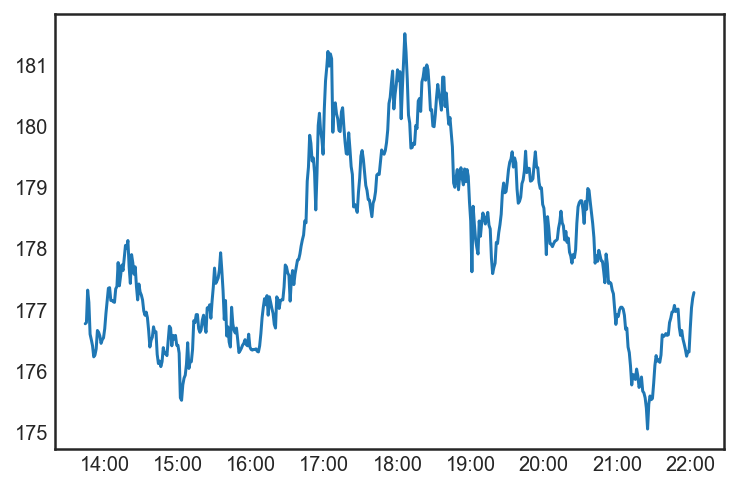

In [15]:
pair = 'ETH/USDT'

ohlcv = binance.fetch_ohlcv(pair, '1m')
prices = [x[4] for x in ohlcv]
dates = [datetime.fromtimestamp(x[0] // 1000) for x in ohlcv]
data = pd.Series(prices, index=dates)
data.plot()

In [19]:
pprint.pprint(ohlcv)
print(len(ohlcv))
print(type(ohlcv))

[[1554745440000, 176.63, 176.84, 176.62, 176.77, 118.94259],
 [1554745500000, 176.73, 176.88, 176.6, 176.79, 299.96308],
 [1554745560000, 176.79, 177.32, 176.76, 177.32, 1078.07028],
 [1554745620000, 177.32, 177.4, 176.93, 177.12, 376.7911],
 [1554745680000, 177.1, 177.14, 176.54, 176.6, 416.82222],
 [1554745740000, 176.6, 176.63, 176.08, 176.51, 366.89645],
 [1554745800000, 176.52, 176.69, 176.33, 176.41, 301.9918],
 [1554745860000, 176.4, 176.4, 176.15, 176.23, 151.50414],
 [1554745920000, 176.26, 176.39, 176.18, 176.26, 115.50373],
 [1554745980000, 176.24, 176.58, 176.23, 176.36, 302.07645],
 [1554746040000, 176.34, 176.69, 176.29, 176.66, 135.99878],
 [1554746100000, 176.66, 176.78, 176.5, 176.63, 176.14235],
 [1554746160000, 176.65, 176.74, 176.48, 176.57, 212.35358],
 [1554746220000, 176.56, 176.67, 176.41, 176.45, 195.50845],
 [1554746280000, 176.5, 176.56, 176.46, 176.51, 128.94682],
 [1554746340000, 176.55, 176.64, 176.49, 176.54, 187.52723],
 [1554746400000, 176.56, 176.72, 1

In [64]:
#pprint.pprint(dir(ccxt.cobinhood()))
pprint.pprint(cobinhood.has)

NameError: name 'cobinhood' is not defined

In [61]:
print(list(binance.markets.keys()))

['ETH/BTC', 'LTC/BTC', 'BNB/BTC', 'NEO/BTC', 'QTUM/ETH', 'EOS/ETH', 'SNT/ETH', 'BNT/ETH', 'BCC/BTC', 'GAS/BTC', 'BNB/ETH', 'BTC/USDT', 'ETH/USDT', 'HSR/BTC', 'OAX/ETH', 'DNT/ETH', 'MCO/ETH', 'ICN/ETH', 'MCO/BTC', 'WTC/BTC', 'WTC/ETH', 'LRC/BTC', 'LRC/ETH', 'QTUM/BTC', 'YOYOW/BTC', 'OMG/BTC', 'OMG/ETH', 'ZRX/BTC', 'ZRX/ETH', 'STRAT/BTC', 'STRAT/ETH', 'SNGLS/BTC', 'SNGLS/ETH', 'BQX/BTC', 'BQX/ETH', 'KNC/BTC', 'KNC/ETH', 'FUN/BTC', 'FUN/ETH', 'SNM/BTC', 'SNM/ETH', 'NEO/ETH', 'IOTA/BTC', 'IOTA/ETH', 'LINK/BTC', 'LINK/ETH', 'XVG/BTC', 'XVG/ETH', 'SALT/BTC', 'SALT/ETH', 'MDA/BTC', 'MDA/ETH', 'MTL/BTC', 'MTL/ETH', 'SUB/BTC', 'SUB/ETH', 'EOS/BTC', 'SNT/BTC', 'ETC/ETH', 'ETC/BTC', 'MTH/BTC', 'MTH/ETH', 'ENG/BTC', 'ENG/ETH', 'DNT/BTC', 'ZEC/BTC', 'ZEC/ETH', 'BNT/BTC', 'AST/BTC', 'AST/ETH', 'DASH/BTC', 'DASH/ETH', 'OAX/BTC', 'ICN/BTC', 'BTG/BTC', 'BTG/ETH', 'EVX/BTC', 'EVX/ETH', 'REQ/BTC', 'REQ/ETH', 'VIB/BTC', 'VIB/ETH', 'HSR/ETH', 'TRX/BTC', 'TRX/ETH', 'POWR/BTC', 'POWR/ETH', 'ARK/BTC', 'ARK/ET